In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
from scipy.signal import convolve2d
from scipy.signal import max_len_seq
import numpy as np
import pyntbci

random.seed(42)
np.random.seed(42)

# Codebook generation for laser pointer visual stimulus

## Condition 1

In [53]:
n_objs = 8

sfreq = 1000
soa = 250
on_duration = 100
off_duration = 150
switch_duration = 500

n_blinks = 12

n_blinked = 0

n_reps = 1

In [54]:
codebook = np.zeros((n_objs, n_blinks * n_objs))

n_blinked = 0
for i in range(codebook.shape[0]):
    for j in range(codebook.shape[1]):
        if codebook[:, j].sum() == 0:
            codebook[i, j] = 1
            n_blinked += 1
        if n_blinked == n_blinks:
            n_blinked = 0
            break

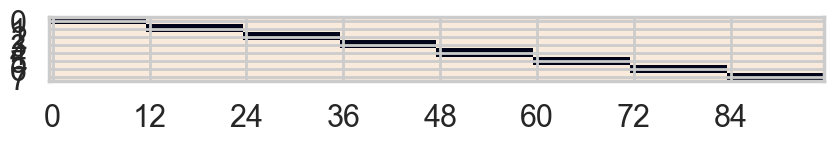

In [55]:
plt.figure(figsize=(10, 10))
plt.imshow(codebook, cmap=sns.cm.rocket_r)
plt.xticks(np.arange(0, codebook.shape[1], n_blinks), np.arange(0, codebook.shape[1], n_blinks))
plt.yticks(np.arange(0, codebook.shape[0]), np.arange(0, codebook.shape[0]))
# plt.grid()
plt.show()

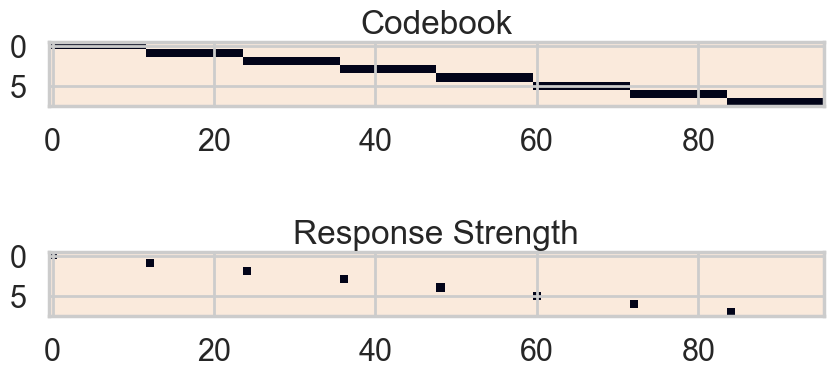

In [56]:
def compute_response(codebook):
    window_high = np.array([0, 0, 0, 0, 0, 1])
    windows = [window_high[i:] for i in range(len(window_high) - 1)][::-1]
    response_strength = np.zeros_like(codebook)
    for window in windows:
        padding = np.zeros((codebook.shape[0], len(window) - 1))
        codebook_padded = np.hstack([padding, codebook])
        for i in range(response_strength.shape[0]):
            for j in range(response_strength.shape[1]):
                if (codebook_padded[i, j:j+len(window)] == window).sum() == len(window):
                    response_strength[i, j] = len(window) + 1
                    
    response_strength = response_strength ** 10
    response_strength = response_strength / response_strength.max()
    
    return response_strength

response_strength = compute_response(codebook)
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
axs[0].imshow(codebook, cmap=sns.cm.rocket_r)
axs[0].set_title('Codebook')
axs[1].imshow(response_strength, cmap=sns.cm.rocket_r)
axs[1].set_title('Response Strength')
plt.show()

## Codebook 2

In [57]:
n_objs = 8

sfreq = 1000
soa = 250
on_duration = 100
off_duration = 150
switch_duration = 500

n_blinks = 12
n_blinked = 0
n_reps = 1
n_highlights = 3

In [58]:
def gen_row(n_objs: int, prev_rows: np.ndarray, n_highlights: int, n_tries: int=1000) -> np.ndarray:
    # Add a row with minimal horizontal distance
    used_idc = []
    for prev_row in prev_rows:
        used_idc += np.where(prev_row == 1)[0].tolist()
    if len(used_idc) == n_objs:
        return np.ones(n_objs) * 99
    
    idc = np.arange(n_objs)
    idc = np.setdiff1d(idc, used_idc)
    for _ in range(n_tries):
        new_idc = np.sort(np.random.choice(idc, size=n_highlights, replace=False))
        idc_diffs = np.abs(np.diff(new_idc))
        row = np.zeros(n_objs)
        row[new_idc] = 1
        if 1 not in idc_diffs:    
            break
        # if i == n_tries - 1:
        #     print('Warning: couldnt find horizontally spaced row!')
    return row

In [59]:
def gen_codebook(init_codebook: np.ndarray, n_objs, n_obj_highlights, n_off_intervals, n_min_highlights):
    assert n_off_intervals < n_objs // n_obj_highlights
    codebook = init_codebook
    while True:
        if n_off_intervals == 0:
            prev_rows = np.zeros((0, n_objs))
        else:
            prev_rows = codebook[-n_off_intervals:].copy()
        new_row = gen_row(n_objs, prev_rows, n_obj_highlights)
        if 99 not in new_row:
            codebook = np.vstack((codebook, new_row))
        if codebook[init_codebook.shape[0]:].sum(axis=0).min() == n_min_highlights:
            break
        
    codebook = codebook[1:]
    codebook = [i for i in codebook.tolist() if i != [2] * n_objs]
    codebook = np.array(codebook)
    return codebook

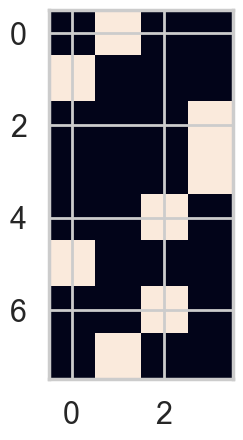

In [60]:
init_codebook = np.zeros((1, n_objs))
codebook = gen_codebook(
    init_codebook = init_codebook,
    n_objs=8, n_obj_highlights=2, n_off_intervals=3, n_min_highlights=1
)
plt.imshow(codebook.T)
plt.show()

<Axes: >

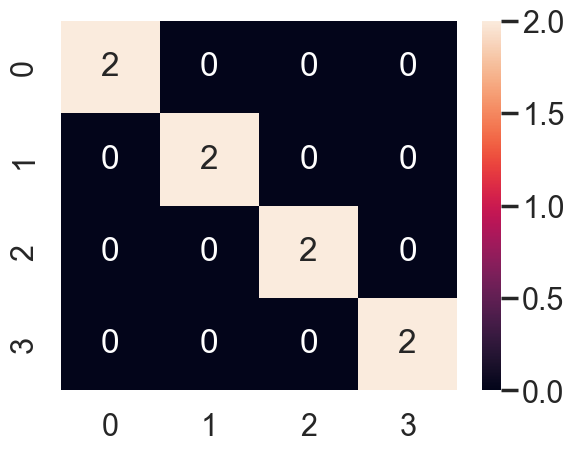

In [61]:
def compute_hamming_distance(codebook: np.ndarray) -> np.ndarray:
    codebook = codebook.copy()
    n_objs = codebook.shape[0]
    
    diffs = np.zeros((n_objs, n_objs))

    for i in range(n_objs):
        for j in range(n_objs):
            seq1 = codebook[i]
            seq1[seq1 == 0] = np.nan
            seq2 = codebook[j]
            seq2[seq2 == 0] = np.nan
            
            diffs[i, j] = (seq1 == seq2).sum()
    return diffs

sns.heatmap(compute_hamming_distance(codebook), annot=True)

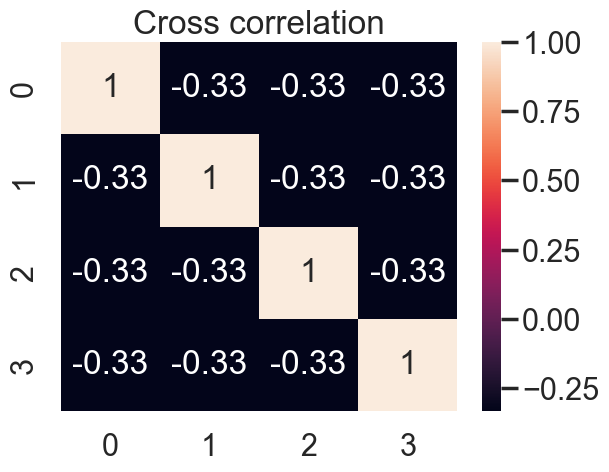

In [62]:
sns.heatmap(np.corrcoef(codebook), annot=True)
plt.title('Cross correlation')
plt.show()

In [63]:
def exist_spatial_neighbors(codebook):
    for i in range(codebook.shape[0]):
        for j in range(codebook.shape[1] - 1):
            if codebook[i, j:j+2].dot(np.array([1, 1])) == 2:
                return True
    return False

def compute_diag_neighbors(codebook: np.ndarray, kernel_size=(3, 3)) -> int:
    kernel_1 = np.zeros(kernel_size)
    np.fill_diagonal(kernel_1, 1)
    kernel_2 = np.zeros(kernel_size)
    np.fill_diagonal(kernel_2, 1)
    kernel_2 = np.flip(kernel_2, axis=1)

    conved_1 = convolve2d(codebook, kernel_1, mode='same')
    conved_2 = convolve2d(codebook, kernel_2, mode='same')
    
    vals_1, cnts_1 = np.unique(conved_1, return_counts=True)
    vals_2, cnts_2 = np.unique(conved_2, return_counts=True)
    
    n_matches = 0
    
    if kernel_size[0] not in vals_1 and kernel_size[0] not in vals_2:
        return n_matches
    else:
        return (cnts_1[vals_1 == kernel_size[0]].sum() + cnts_2[vals_2 == kernel_size[0]].sum()).item()

100%|██████████| 1000/1000 [00:10<00:00, 98.47it/s]

18


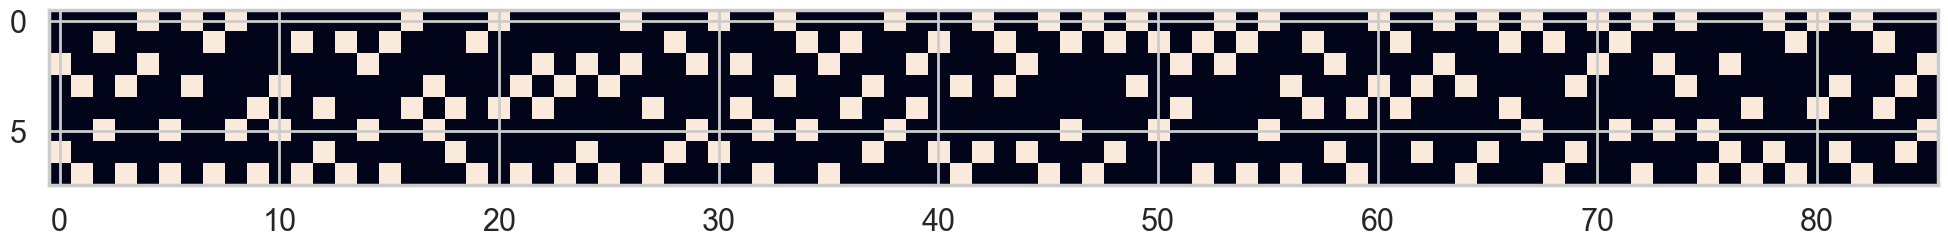

In [64]:
n_reps = 12

for i in range(1):
    best_codebooks = None
    best_diag_val = np.inf
    init_codebook = np.zeros((1, n_objs))
    for _ in tqdm(range(1000)):
        codebooks = []
        init_codebook = gen_codebook(
            init_codebook = init_codebook,
            n_objs=n_objs, n_obj_highlights=2, n_off_intervals=1, n_min_highlights=1
        )
        for _ in range(n_reps):
            while True:
                codebook = gen_codebook(
                    init_codebook = np.zeros((1, n_objs)),
                    n_objs=n_objs, n_obj_highlights=2, n_off_intervals=1, n_min_highlights=1
                )
                prev_idc = np.where(init_codebook[-1] == 1)[0]
                if codebook[0, prev_idc[0]] == 0 and codebook[0, prev_idc[1]] == 0:
                    if not exist_spatial_neighbors(codebook):
                        break
                
            codebooks.append(codebook)
            init_codebook = codebook

        codebooks = np.vstack(codebooks).T
        
        diag_val = compute_diag_neighbors(codebooks, kernel_size=(3, 3))
        if diag_val < best_diag_val:
            
            best_codebooks = codebooks
            best_diag_val = diag_val
            if diag_val == 0:
                break
    print(best_diag_val)
        

    plt.figure(figsize=(20, 20))
    plt.imshow(best_codebooks)
    plt.tight_layout()
    # plt.savefig('./rep_1.png', format='png')
    plt.show()

In [65]:
best_codebooks.shape

(8, 86)

In [66]:
best_codebooks[::2].shape

(4, 86)

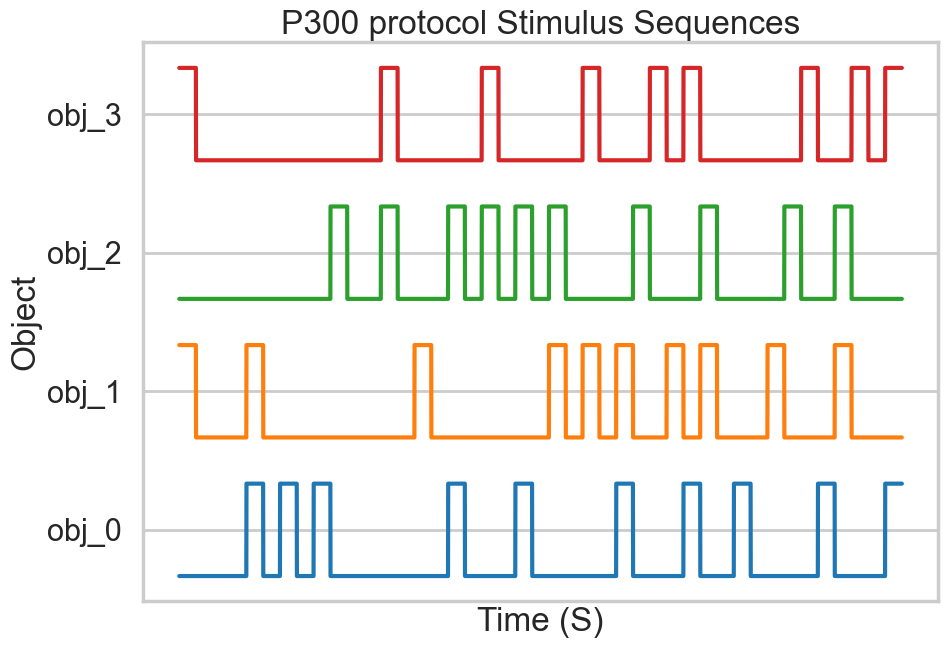

In [107]:
import seaborn as sns
# sns.set_style('whitegrid')
sns.set_context('poster')
plt.figure(figsize=(10, 7))
for i, codebook in enumerate(best_codebooks[::2, :43]):
    plt.plot(np.repeat(codebook + (1.5*i), 100))
plt.yticks(np.arange(0, 6, 1.5) + 0.5, [f'obj_{i}' for i in range(4)])
plt.xticks([])
plt.title('P300 protocol Stimulus Sequences')
plt.ylabel('Object')
plt.xlabel('Time (S)')
plt.tight_layout()
plt.savefig('./images/p300_protocol_sequence_example.png')
plt.show()

In [ ]:
def codebook_to_signal(codebook: np.ndarray, sfreq = 1000, on_duration=100, off_duration=150):
    
    

In [35]:
# codebooks_path = './codebooks/codebook_2.npy'
# if not os.path.exists(codebooks_path):
#     np.save('./codebook_2.npy', best_codebooks)

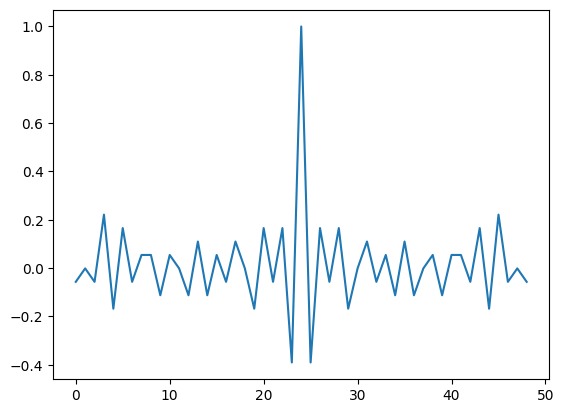

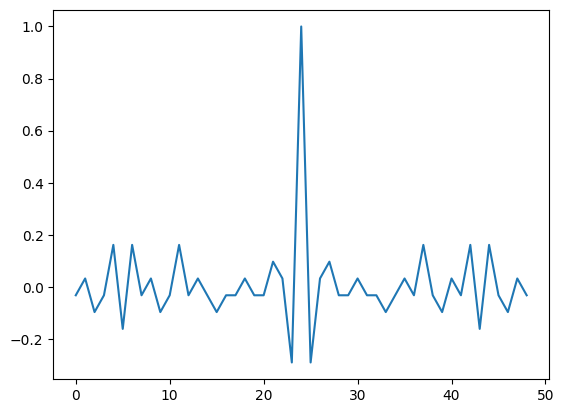

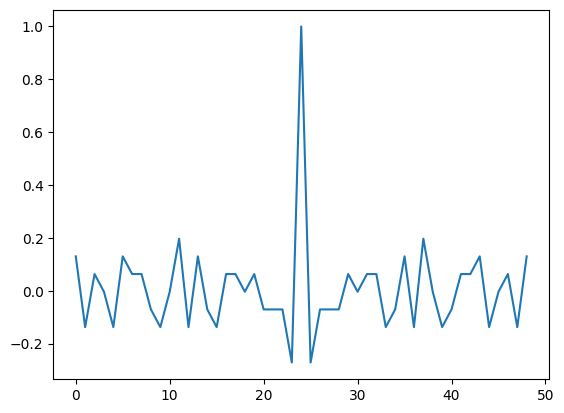

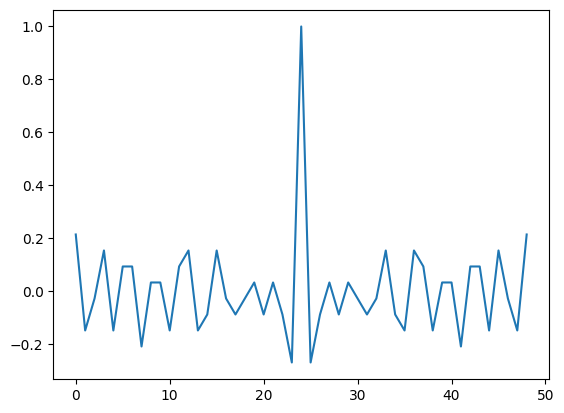

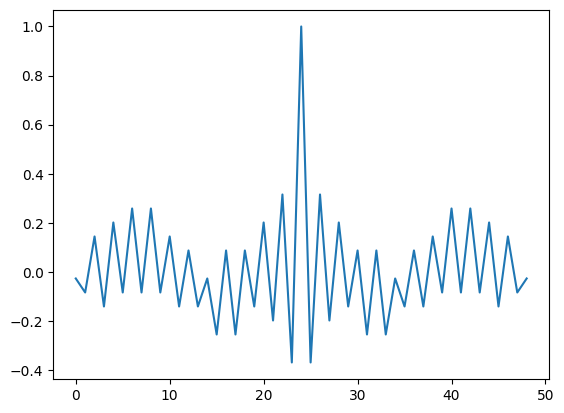

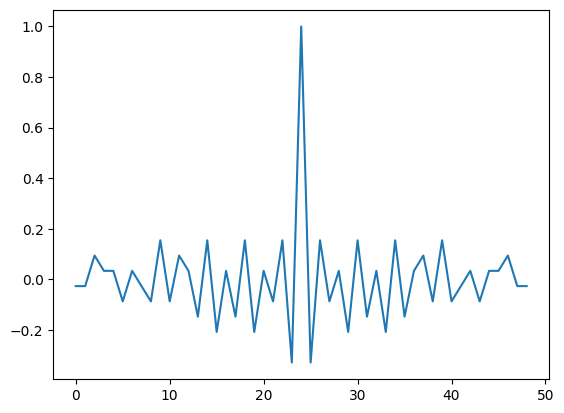

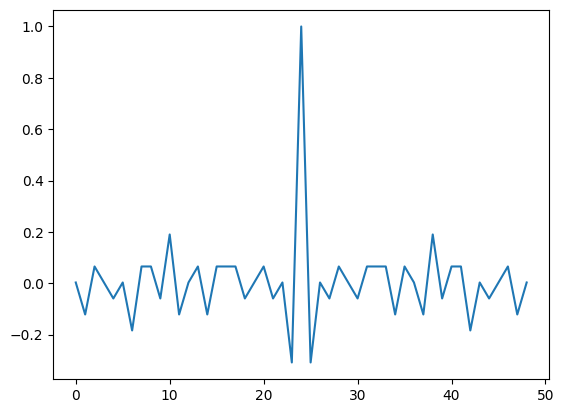

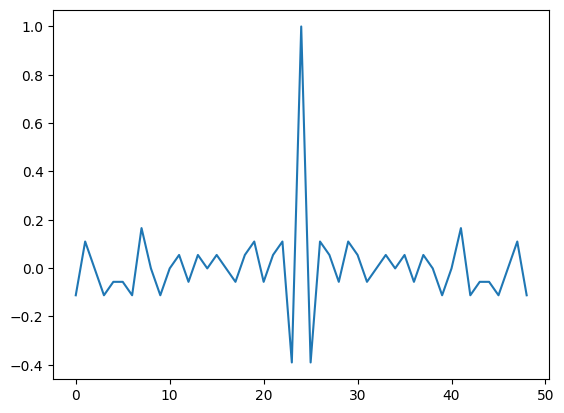

In [36]:
codebooks = best_codebooks
for obj in range(n_objs):
    corrs = []
    for i in range(-24, 25):
        corrs.append(np.corrcoef(codebooks[obj], np.roll(codebooks[obj], i))[0, 1])
    plt.plot(corrs)
    plt.show()

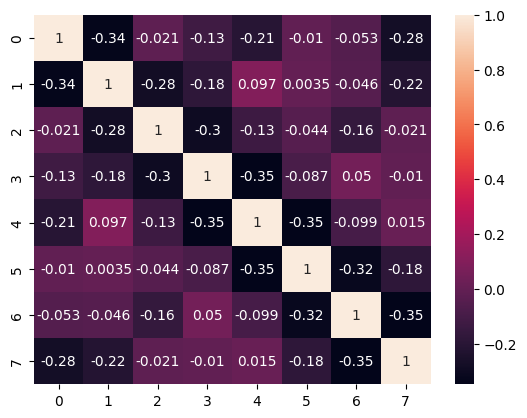

In [37]:
sns.heatmap(np.corrcoef(best_codebooks), annot=True)
plt.show()

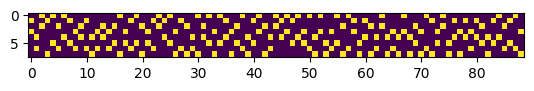

In [38]:
plt.imshow(best_codebooks)
plt.show()

In [ ]:
codebook = best_codebooks

array([[0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
        1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 1., 0.],
       [1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
        1., 0., 0., 1., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
        0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0.

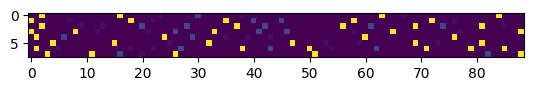

In [39]:
plt.imshow(compute_response(best_codebooks))
plt.show()

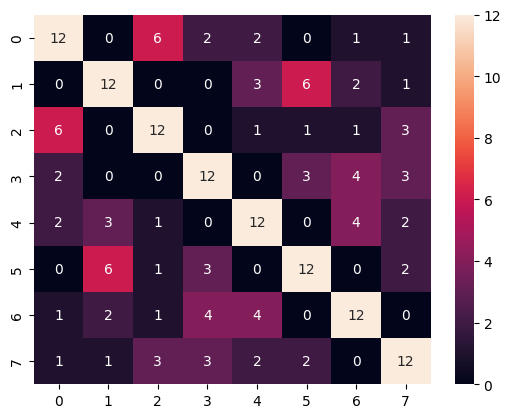

In [19]:
sns.heatmap(compute_hamming_distance(best_codebooks), annot=True)
plt.show()

## Generate m-sequence

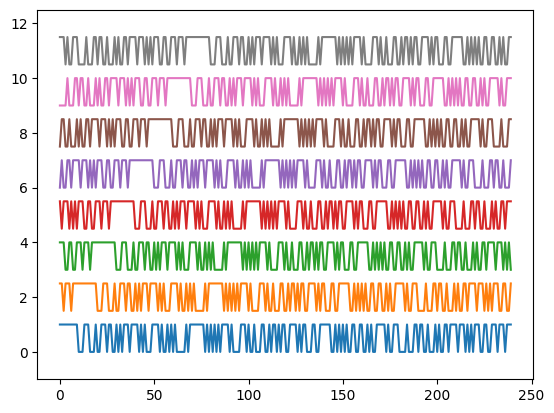

In [ ]:


ms = []
m1, _ = max_len_seq(10, length=240)
ms.append(m1)
for i in range(1, 8):
    ms.append(np.roll(m1, 10 * i))

for i, m in enumerate(ms):
    plt.plot(np.arange(len(m)), m + 1.5 * i)
plt.ylim([-1, 12.5])
plt.show()

In [54]:
ms = np.array(ms)
print(ms.shape)
np.save('./codebook_3_cvep.npy', ms)

(8, 180)


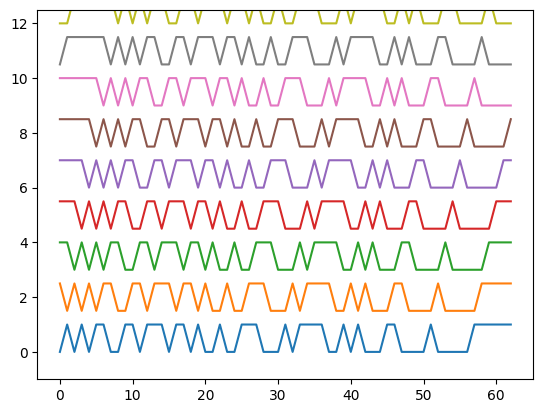

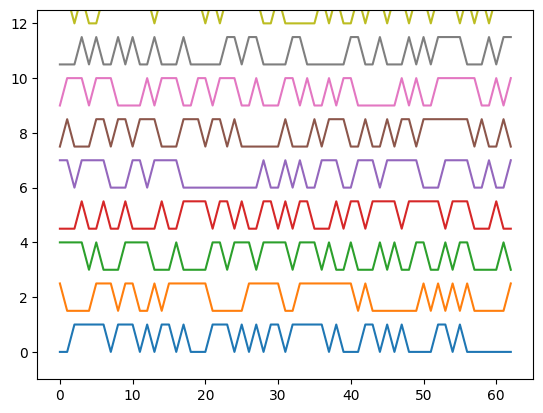

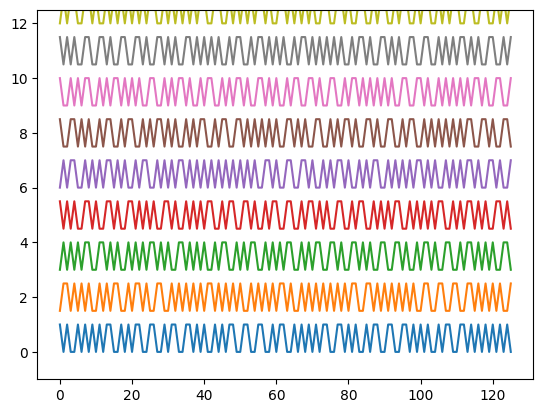

In [ ]:


# Shifted m-sequence
code = pyntbci.stimulus.make_m_sequence(
    poly=[1, 0, 0, 0, 0, 1], base=2, seed=6 * [1], 
)[0, :]
codes = np.zeros((code.size, code.size), dtype="uint8")
for i in range(code.size):
    codes[i, :] = np.roll(code, i)
np.save("mseq_61_shift.npy", codes)  # [codes x bits]
for i, m in enumerate(codes):
    plt.plot(np.arange(len(m)), m + 1.5 * i)
plt.ylim([-1, 12.5])
plt.show()

# Original set of Gold codes
codes = pyntbci.stimulus.make_gold_codes(
    poly1=[1, 0, 0, 0, 0, 1], poly2=[1, 1, 0, 0, 1, 1], seed1=6 * [1], seed2=6 * [1]
)
np.save("gold_61_6521.npy", codes)  # [codes x bits]
for i, m in enumerate(codes):
    plt.plot(np.arange(len(m)), m + 1.5 * i)
plt.ylim([-1, 12.5])
plt.show()

# Modulated set of Gold codes
codes = pyntbci.stimulus.modulate(codes)
np.save("mgold_61_6521.npy", codes)  # [codes x bits]
for i, m in enumerate(codes):
    plt.plot(np.arange(len(m)), m + 1.5 * i)
plt.ylim([-1, 12.5])
plt.show()

In [68]:
codes.shape

(63, 126)

In [1]:
12 * 60

720

In [71]:
1/60

0.016666666666666666

In [65]:
cvep_codebook = np.load('codebooks/condition_3/mseq_61_shift.npy')

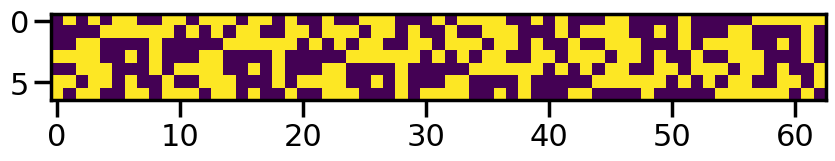

In [66]:
plt.figure(figsize=(10, 7))
plt.imshow(cvep_codebook[:40*4][::10])
plt.show()

In [67]:
cvep_codebook = cvep_codebook[:40*4][::20]
cvep_codebook.shape

(4, 63)

In [68]:
cvep_codebook = np.hstack([cvep_codebook for i in range(60)])

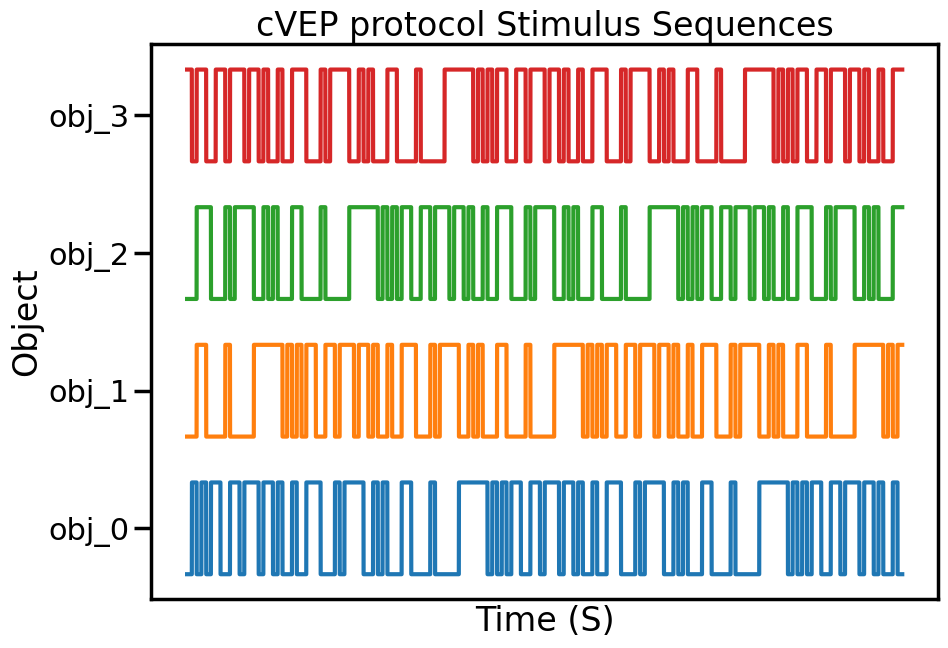

In [69]:
import seaborn as sns
# sns.set_style('whitegrid')
sns.set_context('poster')
plt.figure(figsize=(10, 7))
for i, codebook in enumerate(cvep_codebook[:, :150]):
    plt.plot(np.repeat(codebook + (1.5*i), 100))
plt.yticks(np.arange(0, 6, 1.5) + 0.5, [f'obj_{i}' for i in range(4)])
plt.xticks([])
plt.title('cVEP protocol Stimulus Sequences')
plt.ylabel('Object')
plt.xlabel('Time (S)')
plt.tight_layout()
plt.savefig('./images/cvep_protocol_sequence_example.png')
plt.show()